<img   src="../figures/logos/logo_usc.jpg" align=right  width="12%"/>
<br>

<table width="100%">
<td style="font-size:40px;font-style:italic;text-align:left;background-color:rgba(0, 220, 170,0.7)">
The Art of Measuring II
</td></table>



$ \renewcommand{\bra}[1]{\langle #1|} $
$ \renewcommand{\ket}[1]{|#1\rangle} $
$ \renewcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \renewcommand{\i}{{\color{blue} i}} $ 
$ \renewcommand{\Hil}{{\mathcal H}} $
$ \renewcommand{\boldn}{{\bf n}} $
$ \renewcommand{\tr}{{\rm tr}}$
$ \renewcommand{\Ps}{P} $


In [1]:
import sys
sys.path.append('../')
import macro_tQ as tQ

import numpy as np
import scipy.linalg as la
from IPython.display import display,Markdown,Latex
import matplotlib.pyplot as plt
from qiskit.visualization import array_to_latex

# Multiqubit State Measurements

A measuring device in the base associated with the Hermitian operator 

$$\sigma_z^{\otimes n} = Z\otimes \ldots \otimes Z$$

*collapses* the state it measures to an element 

$$\ket{\psi} \to \ket{x} = \ket{a_{n-1}...a_0}$$ 

of the *computational basis*, which we identify by a bit string $(a_{n-1}...a_0)$ with $a_i=0,1$, where $x= a_{n-1}2^{n-1}+...+2^0 a_0$.


<br>

<figure><center>
<a id='fig_ref'></a>
<img src="images/Multimeter_zbasis.png" align=center width='50%'/>
<center></center>
</center></figure>


## Circuits with Multiple Qubits and Measurements in Qiskit
<br>


Let's initialize a state of 3 qubits 
$$
\ket{\psi} = \sum_{i,j,k = 0,1} c_{ijk} \ket{ijk} = \sum_a c_a \ket{a}
$$

<IPython.core.display.Latex object>

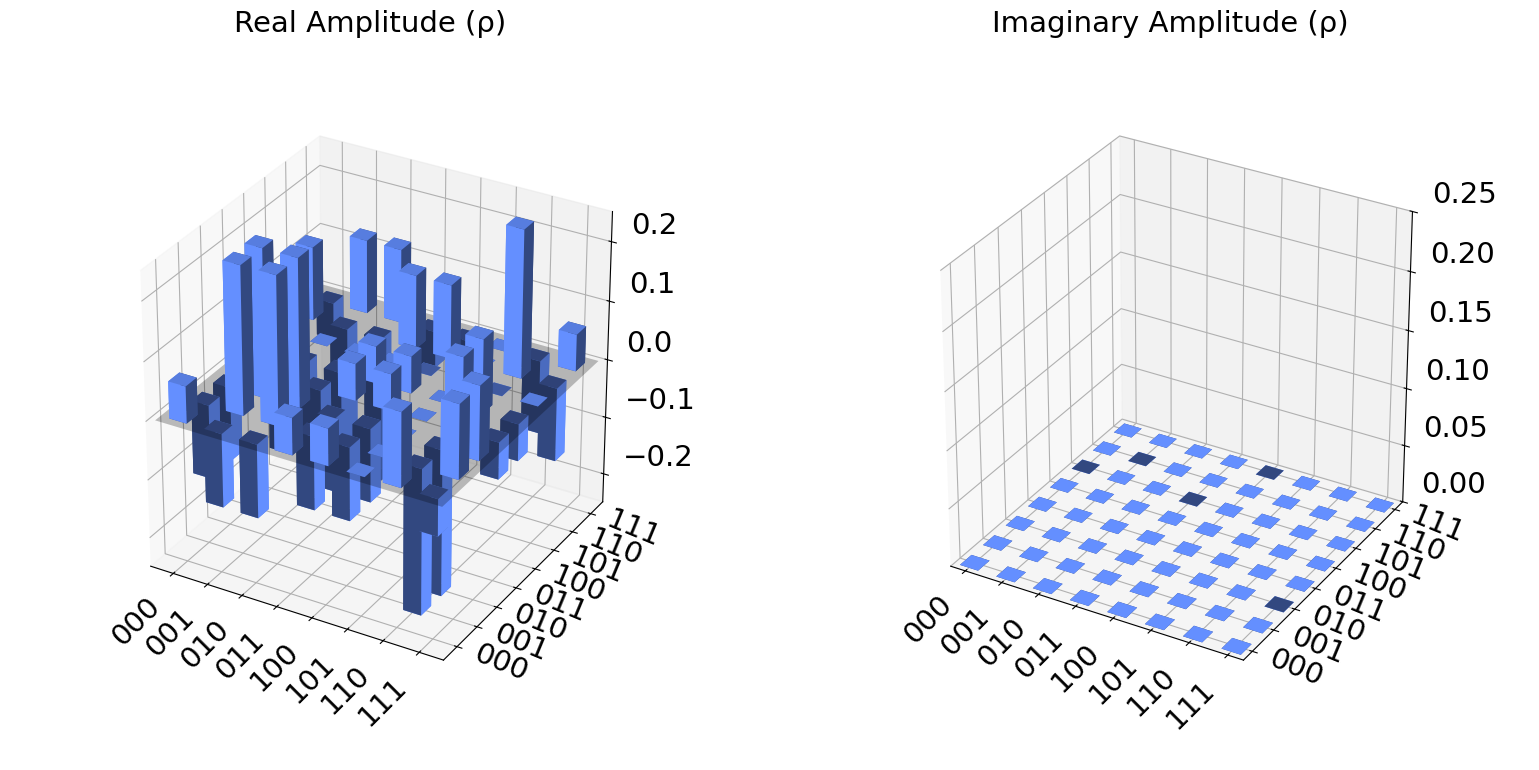

In [28]:
from numpy import linalg as la
from qiskit.quantum_info import Statevector

'''definimos un estado de entrada en H^3$'''
psi =[1.,-2, -2,1,1,0,2,-1]
psi/=la.norm(psi)
#psi = tQ.random_ket(8).reshape(8)

display(Statevector(psi).draw('Latex'))
display(Statevector(psi).draw('City'))

The measurement is essentially a map between n quantum qubits and n classical bits.

$$
\ket{i_{n-1} i_{n-2}\, ... \, i_0} \in \Hil^{\otimes n}  ~~~ \to ~~~ i_{n-1}i_{n-2}...i_0\in \{0,1\}^n
$$

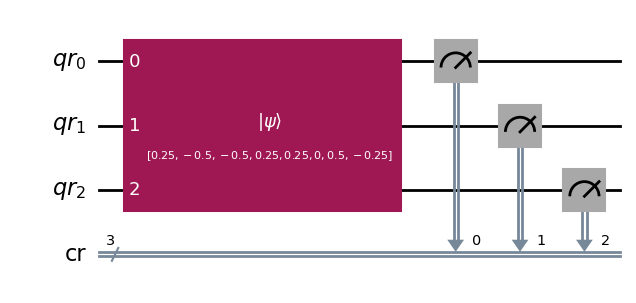

In [32]:
from qiskit import ClassicalRegister, QuantumRegister,QuantumCircuit

qr = QuantumRegister(3,name='qr')
cr = ClassicalRegister(3,name='cr')

qc = QuantumCircuit(qr,cr)
qc.initialize(psi,qr)

qc.measure(qr,cr)
#qc.measure(qr,reversed(list(cr)))  # esta opción invierte la asignación de bits clasicos a cúbits
#qc.measure([qr[0],qr[1]],[cr[1],cr[2]])

qc.draw(output='mpl')

The way to access the amplitudes (state tomography) is by measuring repeatedly to reconstruct the probability function

Cuentas= {'100': 579, '110': 2588, '001': 2479, '111': 603, '011': 617, '010': 2483, '000': 651}


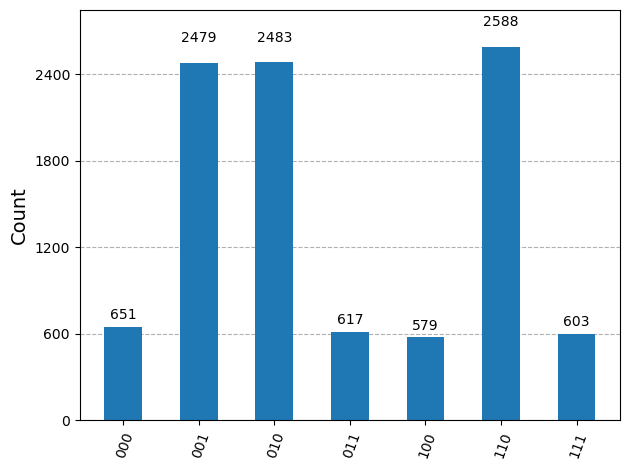

In [40]:
from qiskit_aer import Aer, AerSimulator
#simulator = Aer.get_backend('aer_simulator')
simulator = AerSimulator()
'numero todal de medidas'
nshots = 10000
'ejecutamos el circuito'
counts=simulator.run(qc,shots=nshots).result().get_counts() 
print('Cuentas=',counts) #diccionario de cuentas

from qiskit.visualization import plot_histogram
plot_histogram(counts) # Mostramos un histograma de resultados

Now we can generate dictionaries with the probabilities and amplitudes of the different results, to obtain the tomography of the state

In [41]:
def get_probs(cuentas): # frecuencias_dict es un diccionario con la estadística de resultados
    
    prob_dict=cuentas.copy() # vamos a modificar el diccionario "cuentas" con las probabilidades 
    keys = list(cuentas.keys())
    values = list(cuentas.values())
    
    N=sum(values)
    probabilidades = [v/N for v in values] # lista de frecuencias relativas
 
    for i in range(len(keys)):
        prob_dict[keys[i]]= probabilidades[i]
    
    return  prob_dict

probs = get_probs(counts)

print("Probabilidades =",probs )



Probabilidades = {'100': 0.0579, '110': 0.2588, '001': 0.2479, '111': 0.0603, '011': 0.0617, '010': 0.2483, '000': 0.0651}


# General Base Measures

Let's suppose we want to measure in an **arbitrary orthonormal basis** $\{\ket{ x}'\}$, $x=0,...,2^n-1$. 

$\Rightarrow~ $ we are looking for a circuit that, upon the arrival of a specific vector from the basis $\ket{x}'=\ket{i_{n-1}...i_0}'$, returns exactly *the collection* of bits:  $~i_{n-1}...i_0$.

Let's suppose we know the unitary operator that relates this basis to the computational basis  

$$\ket{ x}'= U\ket{x}~~~~~~\Longrightarrow ~~~~~~   U^\dagger\ket{x}' = \ket{ x}  \, .$$



Then it is evident that we only need to add the operator $U^\dagger$ before the standard meter


<br>

<center>
<figure>
<a id='fig_ref'></a>
<img src="images/Multimeter_basis.png" align=center width='50%'/>
<center></center>
</figure>
</center>


## Pauli Measurements

The most common case involves measuring different qubits in different Pauli bases, $X$, $Y$, or $Z$.

In this case, $U= R_1\otimes \ldots \otimes R_n$ is a product of *local rotations*, $Z\to X$ or $Z\to Y$ 

 For example, the following circuit measures in the base $YXZ \sim Y_2X_1Z_0$

<br>

<center>
<figure>
<a id='fig_ref'></a>
<img src="images/XYZ_multimeter.png" align=center width='35%'/>
<center></center>
</figure>
</center>
<br>

Let's define a function that adds measuring devices in bases $X$, $Y$, or $Z$ from a *string* like 'xxy', etc.

In [42]:
def add_multimeasure_XYZ(qc,paulistring):

    assert(qc.num_qubits==len(paulistring)) #check whether width of circuit coincides with length of Pauli string
    
    # reverse the order of the string to place the rightmost gate at the top
    for i,basis in enumerate(reversed(paulistring)):
        if  basis == 'X':
            qc.h(i)    
            qc.measure(i, i)
        elif basis == 'Z':
            qc.measure(i, i)
            pass    
        elif basis == 'Y':
            qc.sdg(i)
            qc.h(i)
            qc.measure(i, i)

    return qc 

Let's see an example

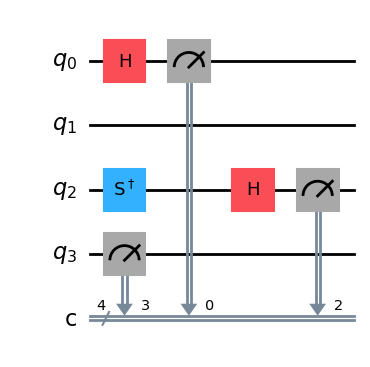

In [43]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(4,4)
add_multimeasure_XYZ(qc,'ZYIX')  # probar a cambiar el aparato de medida
qc.draw('mpl')

## Bell Measurement

The circuit 
<br>

<figure>
<a id='fig_ref'></a>
<center>
<img src="images/Bell_basis.png" align=center width='30%'/>
</center>
</figure>

<br>

 generates the <i>Bell basis</i> $\ket{B_{xy}} = \ket{xy}_B $ from the <i>computational basis</i> $\{\ket{xy}\}$ 
 <br>
<br>

\begin{array}{rcl}
\ket{00}_B &=& \frac{1}{\sqrt{2}} \big( \ket{00} + \ket{11} \big) \\
\ket{01}_B &=& \frac{1}{\sqrt{2}} \big( \ket{00} - \ket{11} \big) \\
\ket{10}_B &=& \frac{1}{\sqrt{2}} \big( \ket{01} + \ket{10} \big) \\
\ket{11}_B &=& \frac{1}{\sqrt{2}} \big( \ket{01} - \ket{10} \big) \\
\end{array}




The circuit that performs a **Bell measurement**  

$$
\ket{xy}_B \to xy
$$
uses the *disentangler* 

$$U^\dagger = ( \hbox{CNOT}\cdot H)^\dagger = H\cdot \hbox{CNOT}$$ 

before the meter 

<br>

<center>
<figure>
<a id='fig_ref'></a>
<img src="images/Bell_meter.png" align=center width='50%'/>
<center></center>
</figure>
</center>


Let's create the Bell measurement

In [44]:
def add_Bell_measurement(qc,qubits=[0,1]):
    qc.cx(qubits[0],qubits[1])
    qc.h(0)
    qc.barrier()
    qc.measure([0,1],[0,1])

And verify

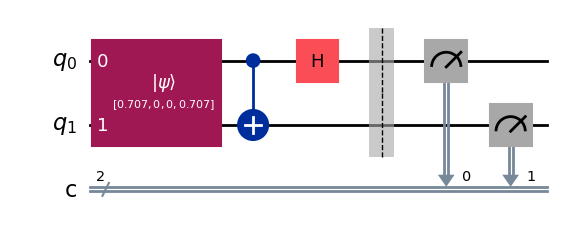

{'00': 10000}

In [48]:
from qiskit import QuantumCircuit

# creamos el circuito
qc = QuantumCircuit(2,2)

# definimos la base de Bell
B00 = np.array([1,0,0,1]/np.sqrt(2))
B01 = np.array([1,0,0,-1]/np.sqrt(2))
B10 = np.array([0,1,1,0]/np.sqrt(2))
B11 = np.array([0,1,-1,0]/np.sqrt(2))

psi = np.array([1,1,1,1])/2
# inicializamos el estado de entrada en cualquiera de los estados anteriores
qc.initialize(B00,[0,1])

# añadimos el medidor en la base de Bell
add_Bell_measurement(qc)
#qc.measure([0,1],[0,1])

display(qc.draw('mpl'))

AerSimulator().run(qc,shots=10000).result().get_counts()

# Expected Values of Multi-Qubit Observables

The *essential* problem in measuring an expected value $\bra{\psi} A \ket{\psi}$ is that, in general, $A$ **is not a unitary operator**. Therefore, it cannot be included as part of a circuit.

If we could express it as a combination of unitary operators, $A = \sum_i c_i U_i$, then we could indeed calculate each expected value $\langle U_i\rangle$ using a circuit and, finally, compose the result $\langle A\rangle = \sum_i c_i \langle U_i\rangle$

A basis is constituted by the *Pauli strings*, $\Ps_{i_1...i_n} = \sigma_{i_1}\otimes \ldots \otimes \sigma_{i_n}$ which are both Hermitian and unitary, and allow the expansion of any Hermitian operator

\begin{equation}
A = \sum_{i_1,...,i_n=0}^3 a_{i_1\ldots i_n} \, \sigma_{i_1}\otimes \ldots \otimes \sigma_{i_n}
 = \sum_{I= 0}^{4^n-1} a_I \Ps_I
\end{equation}

where $\sigma_i = (I,X,Y,Z)$


For example, with $n=3$ 
$$
\Ps_{203} \equiv \sigma_2\otimes \sigma_0 \otimes \sigma_3 =  Y\otimes I\otimes Z 
$$

In Numpy, the Kronecker product is invoked with the function *kron*

In [49]:
' Matrices de Pauli'
s0 = np.matrix([[1,0],[0,1]]) # matriz identidad
s1 = np.matrix([[0,1],[1,0]])
s2 = np.matrix([[0,-1j],[1j,0]])
s3 = np.matrix([[1,0],[0,-1]])

Pauli_basis = [s0,s1,s2,s3]

' Cadena de Pauli YIZ = s2s0s3' 
Pauli_string_203 = np.kron(s3,np.kron(s0,s2))
array_to_latex(Pauli_string_203)

<IPython.core.display.Latex object>

the components can be obtained by calculating the traces
$$
a_{i_1\ldots i_n} =\frac{1}{2^n} \tr \, (A \,  \Ps_{i_1...i_n})
$$


<div class='alert alert-block alert-success'>
<b>Ejercicio </b>; 
demonstrate this result. Show that these coefficients are all real if and only if $A$ is Hermitian.    
</div>

<div class='alert alert-block alert-danger'>
<b>Notice: </b> 
 
- remember that $\tr (O_1\otimes O_2) = \tr (O_1) \tr (O_2)$. 
    
- Also notice that $\tr (A)$ is concentrated in the first component, $\tr (A I) = a_{0...0}$.
</div>

In [50]:
'Arbitrary matrix'
A = np.random.rand(8,8) + 1j* np.random.rand(8,8)
A+= A.conj().T

'Component'
a_203 = np.trace(np.dot(A,Pauli_string_203))/2**3

print('a_{203} = ', a_203)

a_{203} =  (-0.3241997956619531+0j)



Therefore, we only need to find the expected values of Pauli strings
<br>

$$
\langle \Ps_{i_1...i_n}\rangle_\psi = \bra{\psi} \sigma_{i_1}\otimes \ldots   \otimes\sigma_{i_n}\ket{\psi}
$$

in order to compose the final result 
$$
\langle A \rangle_{\psi} =  \sum_{i_1,...,i_n=0}^3 a_{i_1\ldots i_n} \langle \Ps_{i_1...i_n}\rangle_\psi
$$

## Expected Values of Pauli Strings

**Example**: Let's see how to calculate the expected value of the operator
<br>
<br>
$$
\langle Z\otimes Z\otimes Z\rangle_\Psi  = \bra{\Psi}   P_{333} \ket{\Psi}
$$

in the following state

$$
\ket{\psi} = \frac{i}{4}\ket{000}-\frac{i}{2}\ket{001}-\frac{1}{2}\ket{010}+\frac{1}{4}\ket{011}+
\frac{i}{4}\ket{100} + \frac{1}{2}\ket{110} - \frac{1}{4}\ket{111}
$$


First we initialize it

In [51]:
' estado '
psi =np.array([1j,-2*1J, -2,1,1J,0,2,-1])
psi/=tQ.norm(psi)

#e_init = tq_random_ket(8).reshape(8)

from qiskit.quantum_info import Statevector
Statevector(psi).draw('latex')

<IPython.core.display.Latex object>

Given that $Z\ket{a} = (-1)^a\ket{a}$ where $a=0,1$, then we will have that, on a state $\ket{i_2 i_1 i_0}$ of the computational basis
<br>
<br>

$$
Z\otimes Z\otimes Z \ket{i_2 i_1 i_0} = Z\ket{i_2}\otimes Z\ket{i_1}\otimes Z\ket{i_0} = (-1)^{i_2+i_1+i_0}\ket{i_2 i_1 i_0}
$$

<br>

then the expected value of this operator is
<br>
<br>

\begin{eqnarray}
\langle Z\otimes Z\otimes Z\rangle_\Psi &=&
\bra{\Psi} Z\otimes Z\otimes Z \ket{\Psi} \\ 
&=& \sum_{i_2,i_1,i_0=0,1}\bra{\Psi} Z\otimes Z\otimes Z \ket{i_2 i_1 i_0}\braket{i_2 i_1 i_0}{\Psi}  \rule{0mm}{10mm}  \\
&=& \sum_{i_2,i_1,i_0=0,1}(-1)^{i_2 + i_1 + i_0}\big|\bra{i_2 i_1 i_0}\Psi\rangle\big|^2 \\ \rule{0mm}{8mm}
&=& \sum_{i_2,i_1,i_0=0,1} (-1)^{i_2 + i_1 + i_0} p(i_2,i_1,i_0) \nonumber\\ 
\end{eqnarray}

The circuit that calculates the necessary probabilities is the following

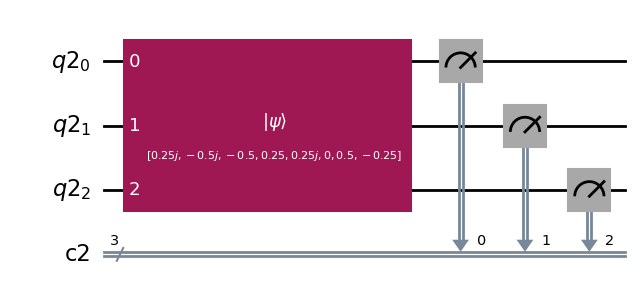

In [52]:
from qiskit import ClassicalRegister, QuantumRegister,QuantumCircuit

qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr,cr)

from qiskit.circuit.library import Initialize

qc.initialize(psi, qr)
qc.measure(qr,cr)
qc.draw(output='mpl')

We run the circuit a number of times and obtain the counts dictionary

counts= {'011': 6170, '111': 6171, '001': 25036, '110': 25115, '100': 6250, '000': 6123, '010': 25135}


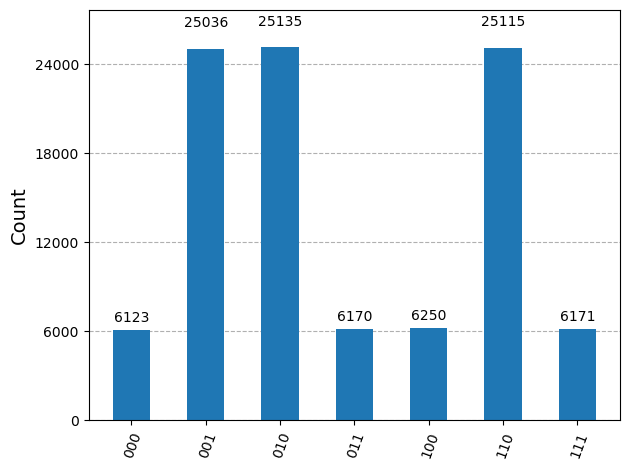

In [53]:
from qiskit_aer import AerSimulator
nshots = 100000


counts = AerSimulator().run(qc,shots=nshots).result().get_counts()
print("counts=", counts)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

Finally, $\langle ZZZ\rangle $ is the mean value of a probability distribution of the form $\{\lambda(x),p(x)\},$ with $x=(i_2 i_1 i_0)$ and

$$
\lambda(x) = (-1)^{i_{2}+i_1+i_0}~~~~~~,~~~~~~ p(x)= \frac{n(x)}{\sum_x n(x)} = \frac{\hbox{counts}(x)}{\hbox{shots}}
$$

The mean will be the expected value we are looking for

$$
 \langle ZZZ\rangle = \bar \lambda = \sum_x \lambda(x) p(x) = \sum_{x}(-1)^{i_{2}+i_1+i_0}\frac{\hbox{counts}(x)}{\hbox{shots}}
$$

In [54]:
mean_ZZZ = 0.
for bitstring,count  in counts.items():
    eigenvalue = (-1)**(sum([int(bit) for bit in bitstring]))
    mean_ZZZ += eigenvalue * count/nshots 

print('<ZZZ> =', np.round(mean_ZZZ,5) )

<ZZZ> = -0.25184


which we can verify with the analytical expression

$$\langle ZZZ\rangle = \bra{\psi} ZZZ\ket{\psi} $$


In [55]:
Z = np.array([[1,0],[0,-1]])
ZZZ = np.kron(Z,np.kron(Z,Z))


vev_ZZZ = np.dot(psi.conj().T,np.dot(ZZZ,psi)).real

print("<ZZZ>=",vev_ZZZ)

<ZZZ>= -0.25


We can also look at the dispersion. For the variance

$$
\sigma^2 = \sum_{x}\left((-1)^{i_{2}+i_1+i_0}-\bar\lambda \right)^2 p(x)
$$

In [56]:
var_ZZZ=0
for bitstring,count  in counts.items():
    var_ZZZ += ((-1)**(sum([int(bit) for bit in bitstring]))-mean_ZZZ)**2 * count/nshots 
    
print('sigma(ZZZ) = ', np.round(np.sqrt(var_ZZZ),4) )

sigma(ZZZ) =  0.9678


and similarly compare with the analytical expression

$$
\sigma = \sqrt{\bra{\psi}\Ps_{ZZZ}^2\ket{\psi} - \bra{\psi}\Ps_{ZZZ}\ket{\psi}^2} =\sqrt{1- \bra{\psi}\Ps_{ZZZ}\ket{\psi}^2}
$$

In [57]:
np.round(np.sqrt(1- mean_ZZZ**2),4)

np.float64(0.9678)

We can also see how to measure the expected value

$$
\langle Z\otimes X\otimes Y\rangle_\Psi  = \bra{\Psi}   Z\otimes X\otimes Y \ket{\Psi}
$$

in the same state

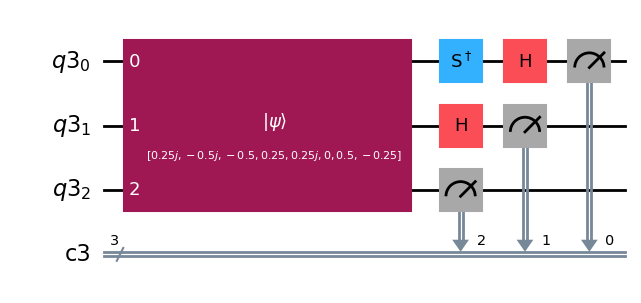

In [58]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

qc2 = QuantumCircuit(qr,cr)


qc2.initialize(psi, qr)
add_multimeasure_XYZ(qc2,'ZXY')
qc2.draw(output='mpl')

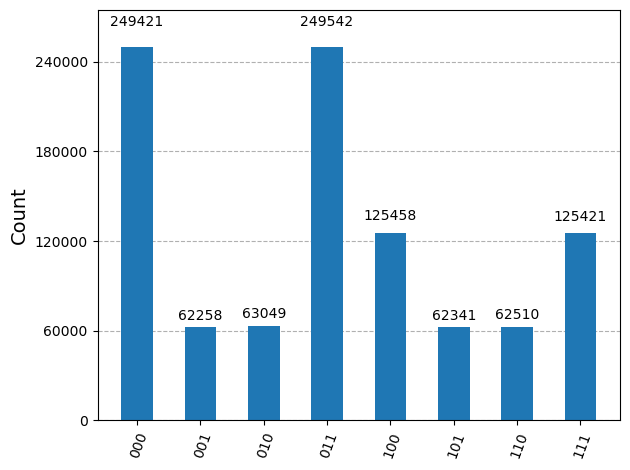

In [59]:
nshots = 1000000

counts2 = AerSimulator().run(qc2,shots=nshots).result().get_counts()
plot_histogram(counts2)

In [60]:
mean = 0
for bitstring,count  in counts2.items():
    mean += (-1)**(sum([int(bit) for bit in bitstring])) * count/nshots 

    
print('<ZXY> =', np.round(mean,5) )

<ZXY> = 0.24763


<div class='alert alert-block alert-success'>
    <b>Exercise </b> 
<br>
write a function $expval\_pauli(P,u)$ that receives as input a state $\ket{u}\in \Hil^{\otimes n}$ and a Pauli string $P = IXYZZ...$ and returns the expected value $\bra{u}P\ket{u}$.
    
</div>

<div class="alert alert-block alert-success">
 <b>Exercise</b>  
    
Consider the Hamiltonian $H=(X X+Y Y+Z Z)$. Show that its eigenvectors are given by the four Bell states $\ket{B_{ij}}$. Compute the energy levels, given by the eigenvalues. 

Check  by obtaining, with a quantum circuit, the expected value of the energy $E = \langle H\rangle_\Psi$ in the four Bell states.
<div>

<div class="alert alert-block alert-success">
 <b>Exercise</b>  
    
write a function $expect\_value(A,\psi)$ that takes as an argument a state $\ket{\psi}$ and an observable $A$, defined over $\Hil^{\otimes n}$, and returns the expected value $\bra{\psi}A\ket{\psi}$. You will need to generate all Pauli strings of length $n$. 
<div>

## Hadamard Test

In the end, the expected value of an operator is a simple number obtained from a random distribution of values.

Couldn't we design a random variable whose average value matches that result?

The Hadamard measure does precisely this **by taking advantage of entanglement**



Let's consider the following circuit

<figure><center>
<a id='fig_ref'></a>
<img src="images/Hadamard_measure.png" align=center width='40%'/>
<center></center>
</center></figure>


The measuring device only records values $\{0,1\}$ as a result of the projective measurements on $\ket{\pm}$

Suppose we measure with the device $x$. The average 

$$
\frac{n_{0}}{N} - \frac{n_{1}}{N} =  + p(0)-p(1) =  \langle X\rangle_{ancilla}
$$

is the expected value of $X$ in the ancilla. 


Analogously, it will be $\langle Y\rangle_{ancilla}$ if we use the device $y$.

We are going to demonstrate the following result that relates this number to the expected value of $U$ in the state $\ket{\psi}$

<div class="alert alert-block alert-info",text-align:center>
<p style="text-align: left ;color: navy;">  
<b>Theorem:</b>
<br>
<br>
$$
\langle X\rangle_{ancilla} = {\rm Re} \langle U\rangle_{\psi} ~~~,~~~ \langle Y\rangle_{ancilla} = {\rm Im} \langle U\rangle_{\psi}\, 
$$
<br>
</div>



**Demonstration**: for the case $x$, the previous circuit will be
<br>
<br>

<figure><center>
<a id='fig_ref'></a>
<img src="images/Hadamard_measurea.png" align=center width='40%'/>
<center></center>
</center></figure>

<br>

An explicit calculation gives us the state that reaches the measuring device
<br>

$$
\ket{0}\ket{\psi} ~~\longrightarrow ~~ \ket{\Psi} = \frac{1}{2} \big[\rule{0mm}{3mm} \ket{0}\otimes  (1 + U) 
|\psi\rangle  + \ket{1}\otimes   (1 - U) \ket{\psi} \big] 
$$


If we measure the ancilla qubit, we will obtain results, values $0$ and $1$ with probabilities 
<br>
<br>
\begin{align} 
 p(0)  &=  \left\vert \frac{1}{2}  (1 + U) \ket{\psi}  \right\vert^{2} = 
 \frac{1}{4}\bra{\psi}(1 + U^\dagger) (1 + U) \ket{\psi} =\frac{1}{2}(1+\operatorname{Re}\langle \psi|U|\psi\rangle) \nonumber\\ \rule{0mm}{12mm}
 p(1)  &= \left\vert \frac{1}{2}  (1 - U) \ket{\psi}  \right\vert^{2}=
 \frac{1}{4}\bra{\psi}(1 - U^\dagger) (1 - U) \ket{\psi} =
 \frac{1}{2}(1-\operatorname{Re}\langle \psi|U|\psi\rangle) \nonumber
\end{align}
<br>


The number $ p(0) - p(1)$ is the expected value of $\langle X\rangle $ in the ancilla state just before the barrier. We find the following result

$$
\langle{X}\rangle_{ancilla}  =  \hbox{Re}\bra{\psi} U \ket{\psi}
$$

Suppose now that we measure in the $Y$ basis, that is, with the following circuit

<br>
<figure><center>
<a id='fig_ref'></a>
<img src="images/Hadamard_measureb.png" align=center width='50%'/>
<center></center>
</center></figure>
<br>

<div class="alert alert-block alert-success">
<b>Exercise 1.2.2.3</b>
<br>   
<br>    
verify that the imaginary part comes from measuring  $\langle Y\rangle$ in the ancilla

$$
\langle{Y}\rangle_{ancilla}  =  \hbox{Im}\bra{\psi} U \ket{\psi} \, .
$$
<br>
</div>

We are going to retrieve the expected value of $\langle Z\otimes Z\otimes Z\rangle_\psi$ in the state 

$$
\ket{\psi} = \frac{i}{4}\ket{000}-\frac{i}{2}\ket{001}-\frac{1}{2}\ket{010}+\frac{1}{4}\ket{011}+
\frac{i}{4}\ket{100} + \frac{1}{2}\ket{110} - \frac{1}{4}\ket{111}
$$

using the Hadamard method. We generate the Hadamard measurement circuit

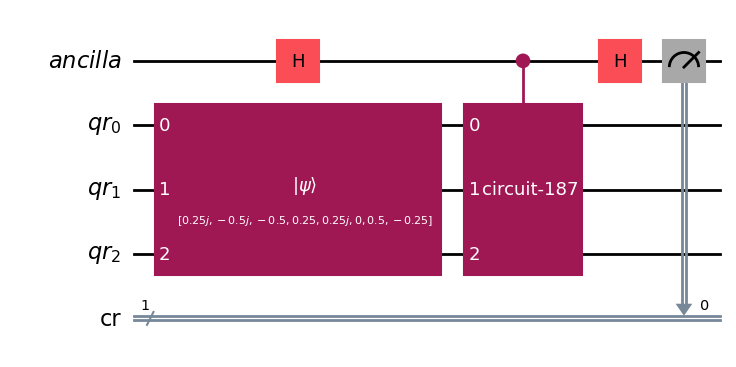

In [61]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister

qr = QuantumRegister(3, name = 'qr')
qra = QuantumRegister(1, name = 'ancilla')
cr = ClassicalRegister(1,"cr")

'creamos el operador como una puerta "gate"  '
qc0 = QuantumCircuit(qr)
qc0.z(qr)
'que admite el método "control" '
CZZZ_gate = qc0.to_gate().control(1,ctrl_state= 1) 

'creamos el circuito con el operador controlado'
qc_Had = QuantumCircuit(qra,qr,cr)
qc_Had.initialize(psi,qr)
qc_Had.h(qra)  
qc_Had.append(CZZZ_gate,qra[:] + qr[:])

'añadimos el aparato de medida en la dirección de X o de Y'
#qc_Had.sdg(qra) #descomentar para Y, comentar para X
qc_Had.h(qra)
qc_Had.measure(qra,cr)

qc_Had.draw('mpl')

We execute and obtain the expected value

Having added a circuit converted into a gate, we need to compile the circuit before executing it

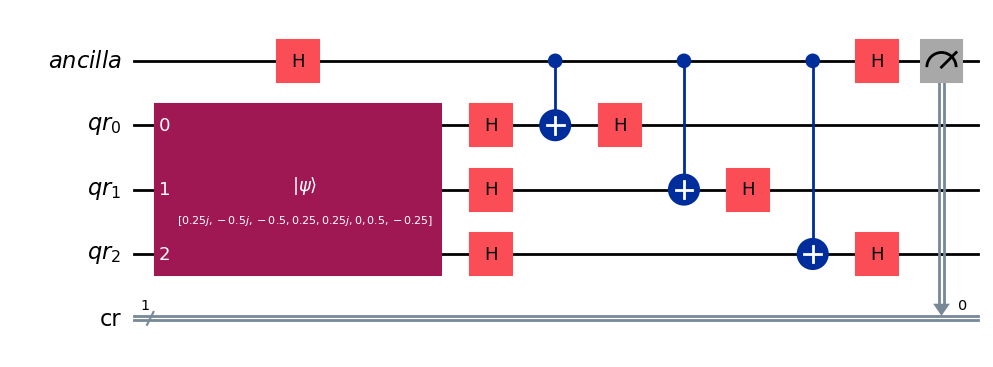

In [62]:
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
nshots = 10000

simulator = AerSimulator()

ac_Had_compiled = transpile(qc_Had,backend = simulator)

counts_Had = simulator.run(ac_Had_compiled,shots=nshots).result().get_counts()

ac_Had_compiled.draw('mpl')

If we wanted to send the circuit to a quantum computer, we would need the Sampler class

https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Sampler


In [63]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

nshots = 1000000

# Run the sampler
result = sampler.run([qc_Had], shots=nshots).result()[0]
counts_Had = result.data.cr.get_counts()


counts= {'1': 624875, '0': 375125}


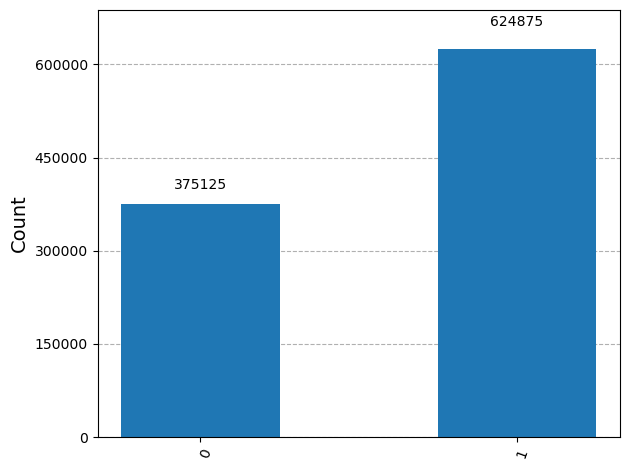

In [64]:
from qiskit.visualization import plot_histogram
print("counts=", counts_Had)
plot_histogram(counts_Had)

In [65]:
mean = 0
for bitstring, count  in counts_Had.items():
    mean += (-1)**(int(bitstring)) * count/nshots

   
print('<X> = Re(<ZZZ>) = <ZZZ> =', np.round(mean,5) )

<X> = Re(<ZZZ>) = <ZZZ> = -0.24975


<div class="alert alert-block alert-success">
    <b>Exercise 1.2.2.5</b> 
    
define a function <i>add_Hadamard_measure</i> that receives a circuit and a Pauli string and adds the associated Hadamard measurement to the circuit.
</div>

## $\langle A \rangle$ with a single circuit

The spectral decomposition of $A$ is

$$
A = \sum_i \lambda_i \ket{\lambda_i}\bra{\lambda_i}
$$
where $\{\ket{\lambda}\}$ forms an orthonormal basis. Hence there exist a unitary operator that maps the computational basis $\{\ket{i}\} $ onto it as follows

$$
\ket{\lambda_i } = U\ket{i}
$$
The expectation value of a certain operator $A$

$$
\langle A \rangle = \sum_i \lambda_i p(\lambda_i) 
$$
only calls for the computation of the probabilities.
Supposing the diagonalization is feasible is a strong assumption, as the dimension of $U$ is $2^n\times 2^n$ in the number of qubits 
$$
p(\lambda_i) = |\braket{\lambda_i}{\psi}|^2 = |\bra{i} U^\dagger\ket{\psi}|^2 = |\braket{i}{\tilde\psi}|^2\, .
$$

In order to obtain this, it is enough to define a circuit
<br>
<img src="images/ev_with_one_circuit.png" width="20%" style="margin:auto"/>

and measure the frecuencies $p(i) = n(i)/N$ of appearance of each of the Z basis eigenvectors.
